In [79]:
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import string, re
import nltk
import os
import subprocess
import shutil
import json
import tensorflow as tf
import keras

from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [80]:
git_dir = '/content/IOH-Chat-App'
git_url = 'https://github.com/bangkit-team/IOH-chat-app.git'

if not os.path.exists(git_dir):
  subprocess.call(['git', 'clone', git_url])

In [81]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
SENTIMENT_CSV = '/content/IOH-chat-app/MachineLearning/datasets/feedbacks/data_feedbacks.csv'

In [83]:
def remove_stopwords(ulasan):
    stopwords = ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 
              'jika', 'sehingga', 'kembali', 'dan', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 
              'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 
              'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 
              'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 
              'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana',
              'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi',
              'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seterusnya', 'tanpa', 'agak',
              'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga',
              'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 'sebetulnya', 'setiap', 'setidaknya',
              'sesuatu', 'pasti', 'saja', 'toh', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun',
              'dengan', 'ia', 'bahwa', 'oleh']

    ulasan = str(ulasan).lower()
    
    words = ulasan.split()
    ulasan = []
    for r in words:
        if not r in stopwords:
            ulasan.append(r)
            
    ulasan=' '.join(ulasan)
    return ulasan

In [84]:
def parse_data_from_file(filename):
    ulasan = []
    label = []
    with open(filename, 'r') as csvfile:
        skip = True
        if skip:
            skip = False
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)

            for row in reader:
                row[0] = remove_stopwords(row[0])
                row[1] = remove_stopwords(row[1])
                label.append(row[0])
                ulasan.append(row[1])
            
    return ulasan, label

In [85]:
ulasan, label = parse_data_from_file(SENTIMENT_CSV)

print(f'Dataset contains {len(ulasan)} examples\n')
print(f'Example 1:\nText: {ulasan[0]}\nLabel :{label[0]}\n')
print(f'Example 2:\nText: {ulasan[1]}\nLabel :{label[1]}\n')

Dataset contains 434 examples

Example 1:
Text: keseluruhan menyukai aplikasi ini, beberapa masalah. beberapa antaranya memasang spoiler media, sebagian besar tidak berfungsi. lainnya (dan jujur, paling menjengkelkan) menggunakan obrolan suara, sering otomatis menutup sendiri beberapa waktu sedang bermain ... full review
Label :1

Example 2:
Text: sebenarnya aplikasi sangat bagus layak. memberi peringkat 4/5 tidak mengirim catatan suara (alias vn). terkadang setengah bangun keyboard lag, tidak mengetik, berarti tidak membalas sms orang. catatan suara sebenarnya sangat berguna sebagian orang! tidak memiliki... ulasan lengkap
Label :1



In [86]:
def preprocess(ulasan):
    ulasan = ulasan.lower() 
    ulasan = ulasan.strip()  
    ulasan = re.compile('<.*?>').sub('', ulasan) 
    ulasan = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', ulasan)  
    ulasan = re.sub('\s+', ' ', ulasan)  
    ulasan = re.sub(r'\[*\]',' ',ulasan) 
    ulasan = re.sub(r'[^\w\s]', '', str(ulasan).lower().strip())
    ulasan = re.sub(r'\d',' ',ulasan) 
    ulasan = re.sub(r'\s+',' ',ulasan) 
    return ulasan

In [87]:
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(ulasan):
    word_pos_tags = nltk.pos_tag(word_tokenize(ulasan))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)

In [88]:
def finalpreprocess(ulasan):
    return lemmatizer(remove_stopwords(preprocess(ulasan)))

In [89]:
df = pd.read_csv(SENTIMENT_CSV)
df

,label,ulasan
0,1,"Secara keseluruhan saya menyukai aplikasi ini,..."
1,1,sebenarnya adalah aplikasi yang sangat bagus...
2,1,Jujur luar biasa. Saya menganggap ini platform...
3,1,Saya beri 4 bintang karena versi PC memiliki f...
4,0,1. Autoscroll ke bawah tidak dapat dinonaktifk...
...,...,...
429,1,Saya mengerti mengapa saya menyukainya
430,0,Yang saya lihat hanyalah payudara
431,0,Asyiknya nge-troll dan ngobrol sama teman di s...
432,1,Bagus


In [90]:
clean_text = df['ulasan'].apply(lambda x: finalpreprocess(x))

label_column = df.pop('label')
df.insert(1, 'label', label_column)

df['ulasan'] = clean_text
df

,ulasan,label
0,keseluruhan menyukai aplikasi ini beberapa mas...,1
1,sebenarnya aplikasi sangat bagus layak memberi...,1
2,jujur luar biasa menganggap ini platform mediu...,1
3,beri bintang versi pc memiliki fitur berpindah...,1
4,autoscroll bawah tidak dinonaktifkan sangat me...,0
...,...,...
429,mengerti menyukainya,1
430,lihat hanyalah payudara,0
431,asyiknya nge troll ngobrol sama teman sini bro,0
432,bagus,1


Class 0 : 215
Class 1 : 219


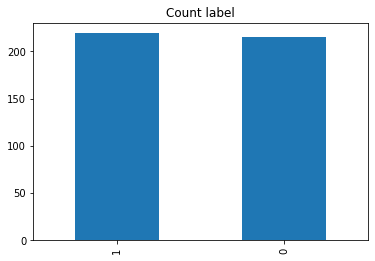

In [91]:
label_count = df['label'].value_counts()

for i in range(0,2):
    print(f'Class {i} : {label_count[i]}')

label_count.plot(kind='bar', title='Count label')
plt.show()

Random Over Sampling
0    215
1    215
Name: label, dtype: int64


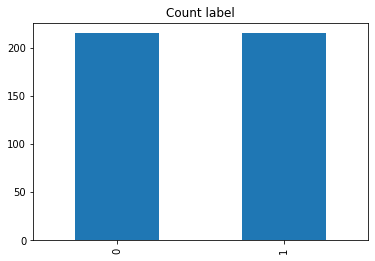

In [92]:
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

df_class_1_over = df_class_1.sample(label_count[0], replace=True)

df_over = pd.concat([
                    df_class_0,
                    df_class_1_over], axis=0)

print('Random Over Sampling')
print(df_over['label'].value_counts())
df_over['label'].value_counts().plot(kind='bar', title='Count label')
plt.show()

In [93]:
EMBEDDING_DIM = 64
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
MAX_EXAMPLES = 16000
TESTING_SPLIT = 0.2
BATCH_SIZE = 64

In [94]:
x = df.ulasan.values
y = df.label.values

In [95]:
MAXLEN = max([len(i) for i in x])
MAXLEN

309

In [96]:
def tokenize(text, num_words, oov_token):
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
  tokenizer.fit_on_texts(text)

  sequences = tokenizer.texts_to_sequences(text)

  return tokenizer

In [97]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  pad_seqs = pad_sequences(
      sequences, padding=padding, truncating=truncating, maxlen=maxlen)

  return pad_seqs

In [98]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TESTING_SPLIT, random_state=1)

print(f'There are {len(x_train)} ulasan for training.')
print(f'There are {len(y_train)} label for training.')
print(f'There are {len(x_test)} ulasan for testing.')
print(f'There are {len(y_test)} label for testing.')

There are 347 ulasan for training.
There are 347 label for training.
There are 87 ulasan for testing.
There are 87 label for testing.


In [105]:
tokenizer = tokenize(x_train, MAX_EXAMPLES, OOV_TOKEN)

index_word = tokenizer.index_word
VOCAB_SIZE = len(index_word)

print(f'Vocabulary contains {VOCAB_SIZE} words')

Vocabulary contains 1388 words


In [106]:
tokenizer_json_dir = '/content/drive/MyDrive/Company Case Bangkit/FeedbacksModel/vocab.json'

tokenizer_json = tokenizer.to_json()
with open(tokenizer_json_dir, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [107]:
x_train_padded = seq_pad_and_trunc(x_train, tokenizer, PADDING, TRUNCATING, MAXLEN)
x_test_padded = seq_pad_and_trunc(x_test, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f'Padded and truncated training sequences have shape: {x_train_padded.shape}')
print(f'Padded and truncated testing sequences have shape: {x_test_padded.shape}')

Padded and truncated training sequences have shape: (347, 309)
Padded and truncated testing sequences have shape: (87, 309)


In [108]:
def create_model(vocab_size, embedding_dim):
  model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  
  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy']) 

  model.summary()

  return model

In [109]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          88896     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              197632    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [110]:
model.fit(
    x_train_padded, y_train, epochs=30, validation_data=(
        x_test_padded, y_test),verbose=1)

Epoch 1/30
11/11 [==============================] - 11s 674ms/step - loss: 0.6949 - accuracy: 0.4582 - val_loss: 0.6927 - val_accuracy: 0.4368
Epoch 2/30
11/11 [==============================] - 6s 591ms/step - loss: 0.6924 - accuracy: 0.5043 - val_loss: 0.6919 - val_accuracy: 0.4598
Epoch 3/30
11/11 [==============================] - 7s 640ms/step - loss: 0.6880 - accuracy: 0.5850 - val_loss: 0.6769 - val_accuracy: 0.7356
Epoch 4/30
11/11 [==============================] - 6s 582ms/step - loss: 0.6627 - accuracy: 0.7032 - val_loss: 0.6202 - val_accuracy: 0.8736
Epoch 5/30
11/11 [==============================] - 6s 583ms/step - loss: 0.5621 - accuracy: 0.7896 - val_loss: 0.3977 - val_accuracy: 0.8621
Epoch 6/30
11/11 [==============================] - 6s 588ms/step - loss: 0.3231 - accuracy: 0.8991 - val_loss: 0.4371 - val_accuracy: 0.8736
Epoch 7/30
11/11 [==============================] - 6s 582ms/step - loss: 0.1737 - accuracy: 0.9625 - val_loss: 0.2596 - val_accuracy: 0.8966
Epoch

In [111]:
export_dir = '/content/drive/MyDrive/Company Case Bangkit/FeedbacksModel/saved_model'

if os.path.exists(export_dir):
  shutil.rmtree(export_dir)

model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Company Case Bangkit/FeedbacksModel/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Company Case Bangkit/FeedbacksModel/saved_model/assets


In [114]:
class FeedbackPredict:
  def __init__(self, model_path, tokenier_json_path, maxlen=309):
    self.model_path = model_path
    self.tokenier_json_path = tokenier_json_path
    self.padding = 'post'
    self.truncating = 'post'
    self.maxlen = maxlen

    self._load_model()
    self._load_tokenizer()

  def _load_model(self):
    self.model = tf.keras.models.load_model(self.model_path, compile=True)
  
  def _load_tokenizer(self):
    with open(self.tokenier_json_path) as f:
      data = json.load(f)
      self.tokenizer = tokenizer_from_json(data)

  def __call__(self, feedback):
    sequences = self.tokenizer.texts_to_sequences([feedback])
    pad_seqs = pad_sequences(sequences, 
                             padding=self.padding, 
                             truncating=self.truncating, 
                             maxlen=self.maxlen)
    
    prediction = self.model.predict(pad_seqs)[0][0]
    return prediction

In [115]:
exp_pos_text = "aplikasi ini sangat bagus desainnya menarik, dan fungsionalitasnya dapat berjalan dengan baik"
exp_neg_text = "jelek banget, chat nya tidak realtime, design nya juga tidak user friendly"

feedback_predict =  FeedbackPredict(export_dir, tokenizer_json_dir)
y_predict = feedback_predict(exp_neg_text)

print(y_predict)

if y_predict >= 0.5:
  print('Positive')
else:
  print('Negative')

0.0011990964
Negative
